In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

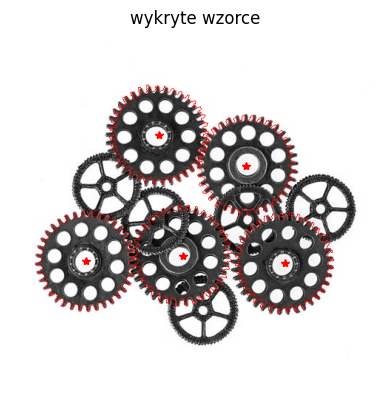

In [2]:
trybik = cv2.imread('trybik.jpg')
gray = cv2.cvtColor(trybik, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
binary = cv2.medianBlur(binary, 5)
binary = cv2.bitwise_not(binary)

# kontury
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# gradienty i orientacje
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
# amplituda gradientu znormalizowana przez wartość max
amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
amplitude /= np.amax(amplitude)
# orientacja gradientu w stopniach
orientation = np.rad2deg(np.arctan2(sobel_y, sobel_x))
orientation = ((orientation + 360) % 360).astype(np.uint16)

# środek ciężkości
moments = cv2.moments(binary, binaryImage=True)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])

# R-table
r_table = [[] for _ in range(360)]
for point in contours[0]:
    x, y = point[0]
    angle = orientation[y, x]
    # wektor łączący kontury z punktem referencyjnym
    dx = x - cx
    dy = y - cy
    # długośc wektora
    r = np.sqrt(dx**2 + dy**2)
    # kąt z osią ox
    fi = np.arctan2(dy, dx)
    r_table[angle].append((r, fi))


trybiki2 = cv2.imread('trybiki2.jpg')
gray = cv2.cvtColor(trybiki2, cv2.COLOR_BGR2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
amplitude /= np.amax(amplitude)

orientation = np.rad2deg(np.arctan2(sobel_y, sobel_x))
orientation = ((orientation + 360) % 360).astype(np.uint16)

new_hough_shape = (np.zeros_like(gray, dtype=np.uint32)).shape + (36 ,)
hough = np.zeros(new_hough_shape)

for y in range(gray.shape[0]):
    for x in range(gray.shape[1]):
        if amplitude[y, x] > 0.5:
            angle = orientation[y, x]
            for d_alpha in range(0, 360, 10):
                alpha_n = int((angle - d_alpha + 360) % 360)
                for r, fi in r_table[alpha_n]:
                    df = np.deg2rad(d_alpha)
                    x1 = int(x - r * np.cos(fi + df))
                    y1 = int(y - r * np.sin(fi + df))
                    if 0 <= x1 < gray.shape[1] and 0 <= y1 < gray.shape[0]:
                        hough[y1, x1, d_alpha // 10] += 1  # mapowanie co 10 stopni na odpowiednie indeksy

delta = 30  # rozmiar otoczenia punktu
maxima = []

for _ in range(5):
    max_idx = np.argmax(hough)
    max_x, max_y, max_angle = np.unravel_index(max_idx, hough.shape)
    maxima.append((max_x, max_y, max_angle))    
    hough[max_x - delta:max_x + delta, max_y - delta:max_y + delta, :] = 0

# kolorowa wersja obrazu w odcieniach szarości
gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
image_with_contours = gray_bgr.copy()

for max_x, max_y, max_angle in maxima:
    plt.plot([max_y], [max_x], '*', color='red')
    angle_rad = np.deg2rad(max_angle * 10)
    translated_contour = []

    for point in contours[0]:
        x, y = point[0]
        dx = x - cx
        dy = y - cy
        r = np.sqrt(dx**2 + dy**2)
        fi = np.arctan2(dy, dx)
        new_x = int(max_y + r * np.cos(fi + angle_rad))
        new_y = int(max_x + r * np.sin(fi + angle_rad))
        translated_contour.append([[new_x, new_y]])

    translated_contour = np.array(translated_contour, dtype=np.int32)
    cv2.drawContours(image_with_contours, [translated_contour], 0, (0, 0, 255), 1)

plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("wykryte wzorce")
plt.show()

dodatkowe krawędzie, zwiększenie dyskretyzacji co 5 kątów (72 zamiast 36)

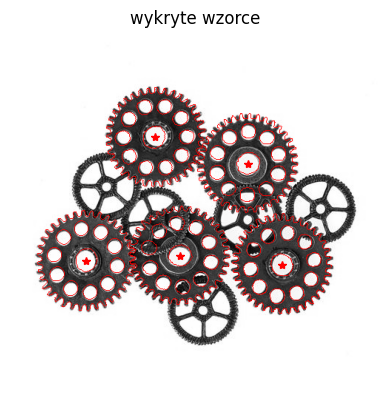

In [3]:

trybik = cv2.imread('trybik.jpg')
gray = cv2.cvtColor(trybik, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
binary = cv2.medianBlur(binary, 5)
binary = cv2.bitwise_not(binary)

# kontury
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# gradienty i orientacje
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    
# amplituda gradientu znormalizowana przez wartość max
amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
amplitude /= np.amax(amplitude)
# orientacja gradientu w stopniach
orientation = np.rad2deg(np.arctan2(sobel_y, sobel_x))
orientation = ((orientation + 360) % 360).astype(np.uint16)

# środek ciężkości
moments = cv2.moments(binary, binaryImage=True)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])

# R-table
r_table = [[] for _ in range(360)] 
for contour in contours:
    for point in contour:
        x, y = point[0]
        angle = orientation[y, x]
        # wektor łączący kontury z punktem referencyjnym
        dx = x - cx
        dy = y - cy
        # długość wektora
        r = np.sqrt(dx**2 + dy**2)
        # kąt z osią ox
        fi = np.arctan2(dy, dx)
        r_table[angle].append((r, fi))  # Dodajemy do r_table


trybiki2 = cv2.imread('trybiki2.jpg')
gray = cv2.cvtColor(trybiki2, cv2.COLOR_BGR2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
amplitude /= np.amax(amplitude)

orientation = np.rad2deg(np.arctan2(sobel_y, sobel_x))
orientation = ((orientation + 360) % 360).astype(np.uint16)

new_hough_shape = (np.zeros_like(gray, dtype=np.uint32)).shape + (72 ,)
hough = np.zeros(new_hough_shape)

for y in range(gray.shape[0]):
    for x in range(gray.shape[1]):
        if amplitude[y, x] > 0.5:
            angle = orientation[y, x]
            for d_alpha in range(0, 360, 5):
                alpha_n = int((angle - d_alpha + 360) % 360)
                for r, fi in r_table[alpha_n]:
                    df = np.deg2rad(d_alpha)
                    x1 = int(x - r * np.cos(fi + df))
                    y1 = int(y - r * np.sin(fi + df))
                    if 0 <= x1 < gray.shape[1] and 0 <= y1 < gray.shape[0]:
                        hough[y1, x1, d_alpha // 5] += 1  # mapowanie co 10 stopni na odpowiednie indeksy

delta = 30  # rozmiar otoczenia punktu
maxima = []

for _ in range(5):
    max_idx = np.argmax(hough)
    max_x, max_y, max_angle = np.unravel_index(max_idx, hough.shape)
    maxima.append((max_x, max_y, max_angle))    
    hough[max_x - delta:max_x + delta, max_y - delta:max_y + delta, :] = 0

# kolorowa wersja obrazu w odcieniach szarości
gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
image_with_contours = gray_bgr.copy()

for max_x, max_y, max_angle in maxima:
    plt.plot([max_y], [max_x], '*', color='red')
    angle_rad = np.deg2rad(max_angle * 5)

    for contour in contours:
        translated_contour = []

        for point in contour:
            x, y = point[0]
            dx = x - cx
            dy = y - cy
            r = np.sqrt(dx**2 + dy**2)
            fi = np.arctan2(dy, dx)
            new_x = int(max_y - r * np.cos(fi + angle_rad))
            new_y = int(max_x - r * np.sin(fi + angle_rad))
            translated_contour.append([[new_x, new_y]])

        translated_contour = np.array(translated_contour, dtype=np.int32)
        cv2.drawContours(image_with_contours, [translated_contour], 0, (0, 0, 255), 1)


plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("wykryte wzorce")
plt.show()
